## Cell 0 — Environment Setup

In [3]:
## Cell 0 — Environment Setup

# ==== Hotfix: Clean install Ultralytics (no runtime restart required) ====
import sys, importlib, subprocess

TARGET_ULTRA = "8.3.202"   # pin a stable Ultralytics version
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--no-deps", f"ultralytics=={TARGET_ULTRA}"], check=True)

# Clear any previously-imported modules to avoid stale state
for m in list(sys.modules):
    if m.startswith("ultralytics"):
        del sys.modules[m]
importlib.invalidate_caches()

import ultralytics
from ultralytics import YOLO
print("Ultralytics version:", ultralytics.__version__)

# ปิด W&B logging
ultralytics.settings.update({'wandb': False})

# ==== Basics (don't touch numpy/torch) ====
!nvidia-smi || true
!pip install -q --no-deps seaborn matplotlib pillow kaggle tqdm jedi
print("✅ Envi ready")


Ultralytics version: 8.3.202
Wed Oct 15 14:13:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------------

## Cell 1 — Kaggle API (Drive fallback)

In [4]:
from pathlib import Path
import os, shutil
from google.colab import drive, files

DRIVE_KAGGLE_JSON = '/content/drive/MyDrive/secrets/kaggle.json'
ok = False
try:
    drive.mount('/content/drive')
    if Path(DRIVE_KAGGLE_JSON).exists():
        Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)
        shutil.copy(DRIVE_KAGGLE_JSON, '/root/.kaggle/kaggle.json')
        os.chmod('/root/.kaggle/kaggle.json', 0o600)
        ok = True
        print("Using kaggle.json from Drive")
except Exception as e:
    print("Skipped Drive mount:", e)

if not ok:
    print("Please upload kaggle.json (Kaggle → Account → Create New Token)")
    up = files.upload()
    assert 'kaggle.json' in up, "kaggle.json is required"
    Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)
    with open('/root/.kaggle/kaggle.json','wb') as f: f.write(up['kaggle.json'])
    os.chmod('/root/.kaggle/kaggle.json', 0o600)

print("✅ Kaggle API ready")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please upload kaggle.json (Kaggle → Account → Create New Token)


Saving kaggle.json to kaggle.json
✅ Kaggle API ready


## Cell 2 — Download Datasets

In [5]:
## Cell 2 — Download Datasets  (with Drive BG fallback)
from pathlib import Path

DATA_BASE     = Path('/content/data')
DATASET1_SLUG = 'muhammetzahitaydn/hardhat-vest-dataset-v3'   # YOLO-format
DATASET2_SLUG = 'gpiosenka/headgear-image-classification'     # classification (caps, hats, hard hat, ...)
DRIVE_HAT_DIR = Path('/content/drive/MyDrive/hat dataset')    # <-- BG จาก Google Drive (ถ้ามี)

DATASET1_DIR  = DATA_BASE/'hardhat_vest_v3'
DATASET2_DIR  = DATA_BASE/'headgear'      # จะใช้ถ้าไม่มี DRIVE_HAT_DIR
MERGED_DIR    = Path('/content/helmet_merged')
YOLO_ROOT     = Path('/content/helmet_yolo_2c')
PROJECT_NAME  = "helmet_yolo_2c"
MODEL         = 'yolov8n'
SEED          = 12345

DATA_BASE.mkdir(parents=True, exist_ok=True)

# -------- Hardhat-Vest (label พร้อม) --------
!kaggle datasets download -d {DATASET1_SLUG} -p {DATA_BASE}
!unzip -q -o {DATA_BASE}/*.zip -d {DATASET1_DIR}
print("✅ Hardhat-Vest ready:", DATASET1_DIR)

# -------- BG source: ใช้ Drive ถ้ามี ไม่งั้นใช้ Kaggle --------
if DRIVE_HAT_DIR.exists():
    print(f"✅ Using BG from Google Drive: {DRIVE_HAT_DIR}")
    BG_SOURCE_MODE = "drive"     # จะถูกอ่านใน Cell 4
else:
    print("ℹ️ Drive BG not found → fallback to Kaggle headgear dataset")
    !kaggle datasets download -d {DATASET2_SLUG} -p {DATA_BASE}
    !unzip -q -o {DATA_BASE}/*.zip -d {DATASET2_DIR}
    print("✅ Headgear ready:", DATASET2_DIR)
    BG_SOURCE_MODE = "kaggle"    # จะถูกอ่านใน Cell 4

# เก็บ path ไว้ใช้ใน Cell 4
print("BG_SOURCE_MODE =", BG_SOURCE_MODE)


Dataset URL: https://www.kaggle.com/datasets/muhammetzahitaydn/hardhat-vest-dataset-v3
License(s): CC0-1.0
 98% 4.14G/4.21G [00:11<00:00, 618MB/s]
100% 4.21G/4.21G [00:11<00:00, 378MB/s]
✅ Hardhat-Vest ready: /content/data/hardhat_vest_v3
✅ Using BG from Google Drive: /content/drive/MyDrive/hat dataset
BG_SOURCE_MODE = drive


## Cell 3 — Merge & Remap (2 classes: 0 no-helmet, 1 safety-helmet)

In [6]:
import shutil, cv2
from tqdm import tqdm
from pathlib import Path

if MERGED_DIR.exists(): shutil.rmtree(MERGED_DIR)
for d in ['images/train','images/val','images/test','labels/train','labels/val','labels/test']:
    (MERGED_DIR/d).mkdir(parents=True, exist_ok=True)

# --- Merge Hardhat-Vest with remap ---
src_img = DATASET1_DIR/'images'
src_lbl = DATASET1_DIR/'labels'

classes_txt = list(DATASET1_DIR.rglob("classes.txt"))
if classes_txt:
    names1 = [ln.strip() for ln in classes_txt[0].read_text().splitlines() if ln.strip()]
    no_helmet_ids = [i for i,n in enumerate(names1) if 'no' in n.lower() and 'helmet' in n.lower()]
    hardhat_ids   = [i for i,n in enumerate(names1) if 'helmet' in n.lower() and 'no' not in n.lower()]
else:
    names1 = []
    no_helmet_ids, hardhat_ids = [3], [1]  # fallback guess

def remap_line(line:str):
    sp=line.strip().split()
    if len(sp)<5: return None
    cid=int(float(sp[0]))
    if cid in no_helmet_ids: new_c=0
    elif cid in hardhat_ids: new_c=1
    else: return None
    return " ".join([str(new_c)] + sp[1:5])

kept = 0
for split in ['train','val','test']:
    for img in (src_img/split).rglob("*.jpg"):
        lbl = (src_lbl/split/img.stem).with_suffix(".txt")
        if not lbl.exists(): continue
        lines = [remap_line(x) for x in lbl.read_text().splitlines()]
        lines = [x for x in lines if x]
        if not lines: continue
        shutil.copy2(img, MERGED_DIR/f"images/{split}/{img.name}")
        with open(MERGED_DIR/f"labels/{split}/{img.stem}.txt","w") as f: f.write("\n".join(lines)+"\n")
        kept += 1
print(f"Hardhat merged, kept pairs: {kept}")

Hardhat merged, kept pairs: 13005


## Cell 4 — Build strict split + Inject BG (caps→no-helmet)

In [7]:
## Cell 4 — Build strict split + Inject BG (caps→no-helmet)

from tqdm import tqdm
import random, shutil
from pathlib import Path

# =========================
# 1) Build strict split to YOLO_ROOT  (ใช้เฉพาะคู่ภาพ+label จาก Hardhat-Vest)
# =========================
if YOLO_ROOT.exists():
    shutil.rmtree(YOLO_ROOT)
for d in ['images/train','images/val','images/test','labels/train','labels/val','labels/test']:
    (YOLO_ROOT/d).mkdir(parents=True, exist_ok=True)

pairs = []
for sp in ['train','val','test']:
    for img in (MERGED_DIR/f"images/{sp}").glob("*.jpg"):
        lbl = (MERGED_DIR/f"labels/{sp}/{img.stem}.txt")
        if lbl.exists() and lbl.read_text().strip():
            pairs.append((sp, img, lbl))

for sp, img, lbl in tqdm(pairs, desc="copy pairs"):
    shutil.copy2(img, YOLO_ROOT/f"images/{sp}/{img.name}")
    shutil.copy2(lbl, YOLO_ROOT/f"labels/{sp}/{img.stem}.txt")

print(f"✅ Copied labeled pairs: {len(pairs)}")

# =========================
# 2) Collect BG images (Drive first, else Kaggle)
#    → label class-0 (no-helmet) เป็น weak-label ครอบทั้งภาพ
# =========================

# ---- (A) จาก Google Drive: ใช้ whitelist ----
DRIVE_BG_ROOT = DRIVE_HAT_DIR

WHITELIST_FOLDERS = {

    "ASCOT CAP",
    "Baseball cap",
    "boater",
    "DEERSTALKER",
    "FEDORA",
    "FEZ",
    "MOTARBOARD",
    "PORK PIE",
    "SOMBERO",
    "TOP HAT",
    "ZUCCHETTO",
    "headphone",
    "no-Helmet",

}

def collect_bg_from_drive(root: Path) -> list[Path]:
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    imgs = []
    if not root.exists():
        return imgs


    for cls_dir in root.iterdir():
        if not cls_dir.is_dir():
            continue
        name = cls_dir.name
        if any(name.lower() == w.lower() for w in WHITELIST_FOLDERS):
            for p in cls_dir.rglob("*"):
                if p.is_file() and p.suffix.lower() in exts:
                    imgs.append(p)
    return imgs

# ---- (B) จาก Kaggle headgear: ตัด "HARD HAT"/"SAFETY" ออก ที่เหลือใช้เป็น BG ----
def collect_bg_from_kaggle(train_root: Path) -> list[Path]:
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    imgs = []
    if not train_root.exists():
        return imgs
    for cls_dir in train_root.iterdir():
        if not cls_dir.is_dir():
            continue
        cname = cls_dir.name.upper()
        if "HARD HAT" in cname or "SAFETY" in cname:
            continue
        for p in cls_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                imgs.append(p)
    return imgs

# เลือกแหล่ง BG
if 'BG_SOURCE_MODE' in globals() and BG_SOURCE_MODE == "drive":
    bg_candidates = collect_bg_from_drive(DRIVE_BG_ROOT)
    src_note = f"Drive ({DRIVE_BG_ROOT}) [whitelist+no-Helmet]"
else:
    bg_candidates = collect_bg_from_kaggle(DATASET2_DIR/'train')
    src_note = f"Kaggle ({DATASET2_DIR/'train'}) [exclude HARD HAT]"

print(f"🧢 BG candidates from {src_note}: {len(bg_candidates)}")

# =========================
# 3) Inject BG เฉพาะ TRAIN (เพื่อให้ val/test เป็นการประเมินจริง)
# =========================
random.seed(SEED)
MAX_BG_TOTAL = 6000
take = min(MAX_BG_TOTAL, len(bg_candidates))
bg_take = random.sample(bg_candidates, take)

def inject_bg_train(bg_list):
    out_img_dir = YOLO_ROOT/'images/train'
    out_lbl_dir = YOLO_ROOT/'labels/train'
    count = 0
    for i, img in enumerate(tqdm(bg_list, desc="inject BG → train (class 0)")):
        # กันชื่อไฟล์ชนกันข้ามชุด/ข้ามที่มา
        safe_name = f"bg_{img.parent.name}_{img.stem}_{i:05d}{img.suffix.lower()}"
        dst_img = out_img_dir/safe_name
        dst_lbl = out_lbl_dir/f"{Path(safe_name).stem}.txt"
        try:
            shutil.copy2(img, dst_img)
            # weak label: bbox ทั้งรูป (cx, cy, w, h) = (0.5, 0.5, 1, 1)
            dst_lbl.write_text("0 0.5 0.5 1.0 1.0\n", encoding="utf-8")
            count += 1
        except Exception:
            pass
    return count

cnt_tr = inject_bg_train(bg_take)

print(f"✅ BG injected to TRAIN only: {cnt_tr} images")

# =========================
# 4) Write data.yaml
# =========================
DATA_YAML = YOLO_ROOT/'helmet.yaml'
DATA_YAML.write_text(
    "path: {}\n"
    "train: images/train\n"
    "val: images/val\n"
    "test: images/test\n"
    "names:\n"
    "  0: no-helmet\n"
    "  1: safety-helmet\n".format(YOLO_ROOT),
    encoding="utf-8"
)
print("===== DATA YAML =====\n", DATA_YAML.read_text())


copy pairs: 100%|██████████| 13005/13005 [00:04<00:00, 3169.95it/s]


✅ Copied labeled pairs: 13005
🧢 BG candidates from Drive (/content/drive/MyDrive/hat dataset) [whitelist+no-Helmet]: 231


inject BG → train (class 0): 100%|██████████| 231/231 [01:04<00:00,  3.56it/s]

✅ BG injected to TRAIN only: 231 images
===== DATA YAML =====
 path: /content/helmet_yolo_2c
train: images/train
val: images/val
test: images/test
names:
  0: no-helmet
  1: safety-helmet



## Cell 5 — Train YOLOv8

In [ ]:
## Cell 5 — Train YOLOv8 (Optimized)

from ultralytics import YOLO
import glob, os
from pathlib import Path

# clear .cache files
for p in glob.glob(str(YOLO_ROOT/"**/*.cache"), recursive=True):
    try: os.remove(p)
    except: pass

model = YOLO("yolov8n.pt")

results = model.train(
    data=str(DATA_YAML),
    epochs=1,         # ปรับ เหลือ 1 เพราะ Demo การทำงาน
    imgsz=640,
    batch=32,
    lr0=0.001,
    project="helmet_yolo_2c",
    name="helmet_run",
    pretrained=True,
    seed=12345,  # กำหนดให้ seed เท่ากันตลอด
    workers=4,
    cache="ram",
    half=True,
    patience=10,
    cos_lr=True,
    close_mosaic=10,
    save_period=-1,
    device=0
)
SAVE_MODEL_PATH = Path(results.save_dir) / "weights" / "best.pt"
print("✅ Training done. best.pt:", SAVE_MODEL_PATH)


New https://pypi.org/project/ultralytics/8.3.214 available 😃 Update with 'pip install -U ultralytics'
New https://pypi.org/project/ultralytics/8.3.214 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.202 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Ultralytics 8.3.202 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/helmet_yolo_2c/helmet.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=

## Cell 6 — Validate on Test set + show plots

✅ Loaded model: /content/helmet_yolo_2c/helmet_run/weights/best.pt
Ultralytics 8.3.202 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Ultralytics 8.3.202 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2265.3±594.9 MB/s, size: 121.4 KB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2265.3±594.9 MB/s, size: 121.4 KB)
val: Scanning /content/helmet_yolo_2c/labels/test... 1380 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1380/1380 1.5Kit/s 0.9s
val: New cache created: /content/helmet_yolo_2c/labels/test.cache
val: New cache created: /content/helmet_yolo_2c/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 87/87 10.9it/s 8.0s
                   all       1380       4

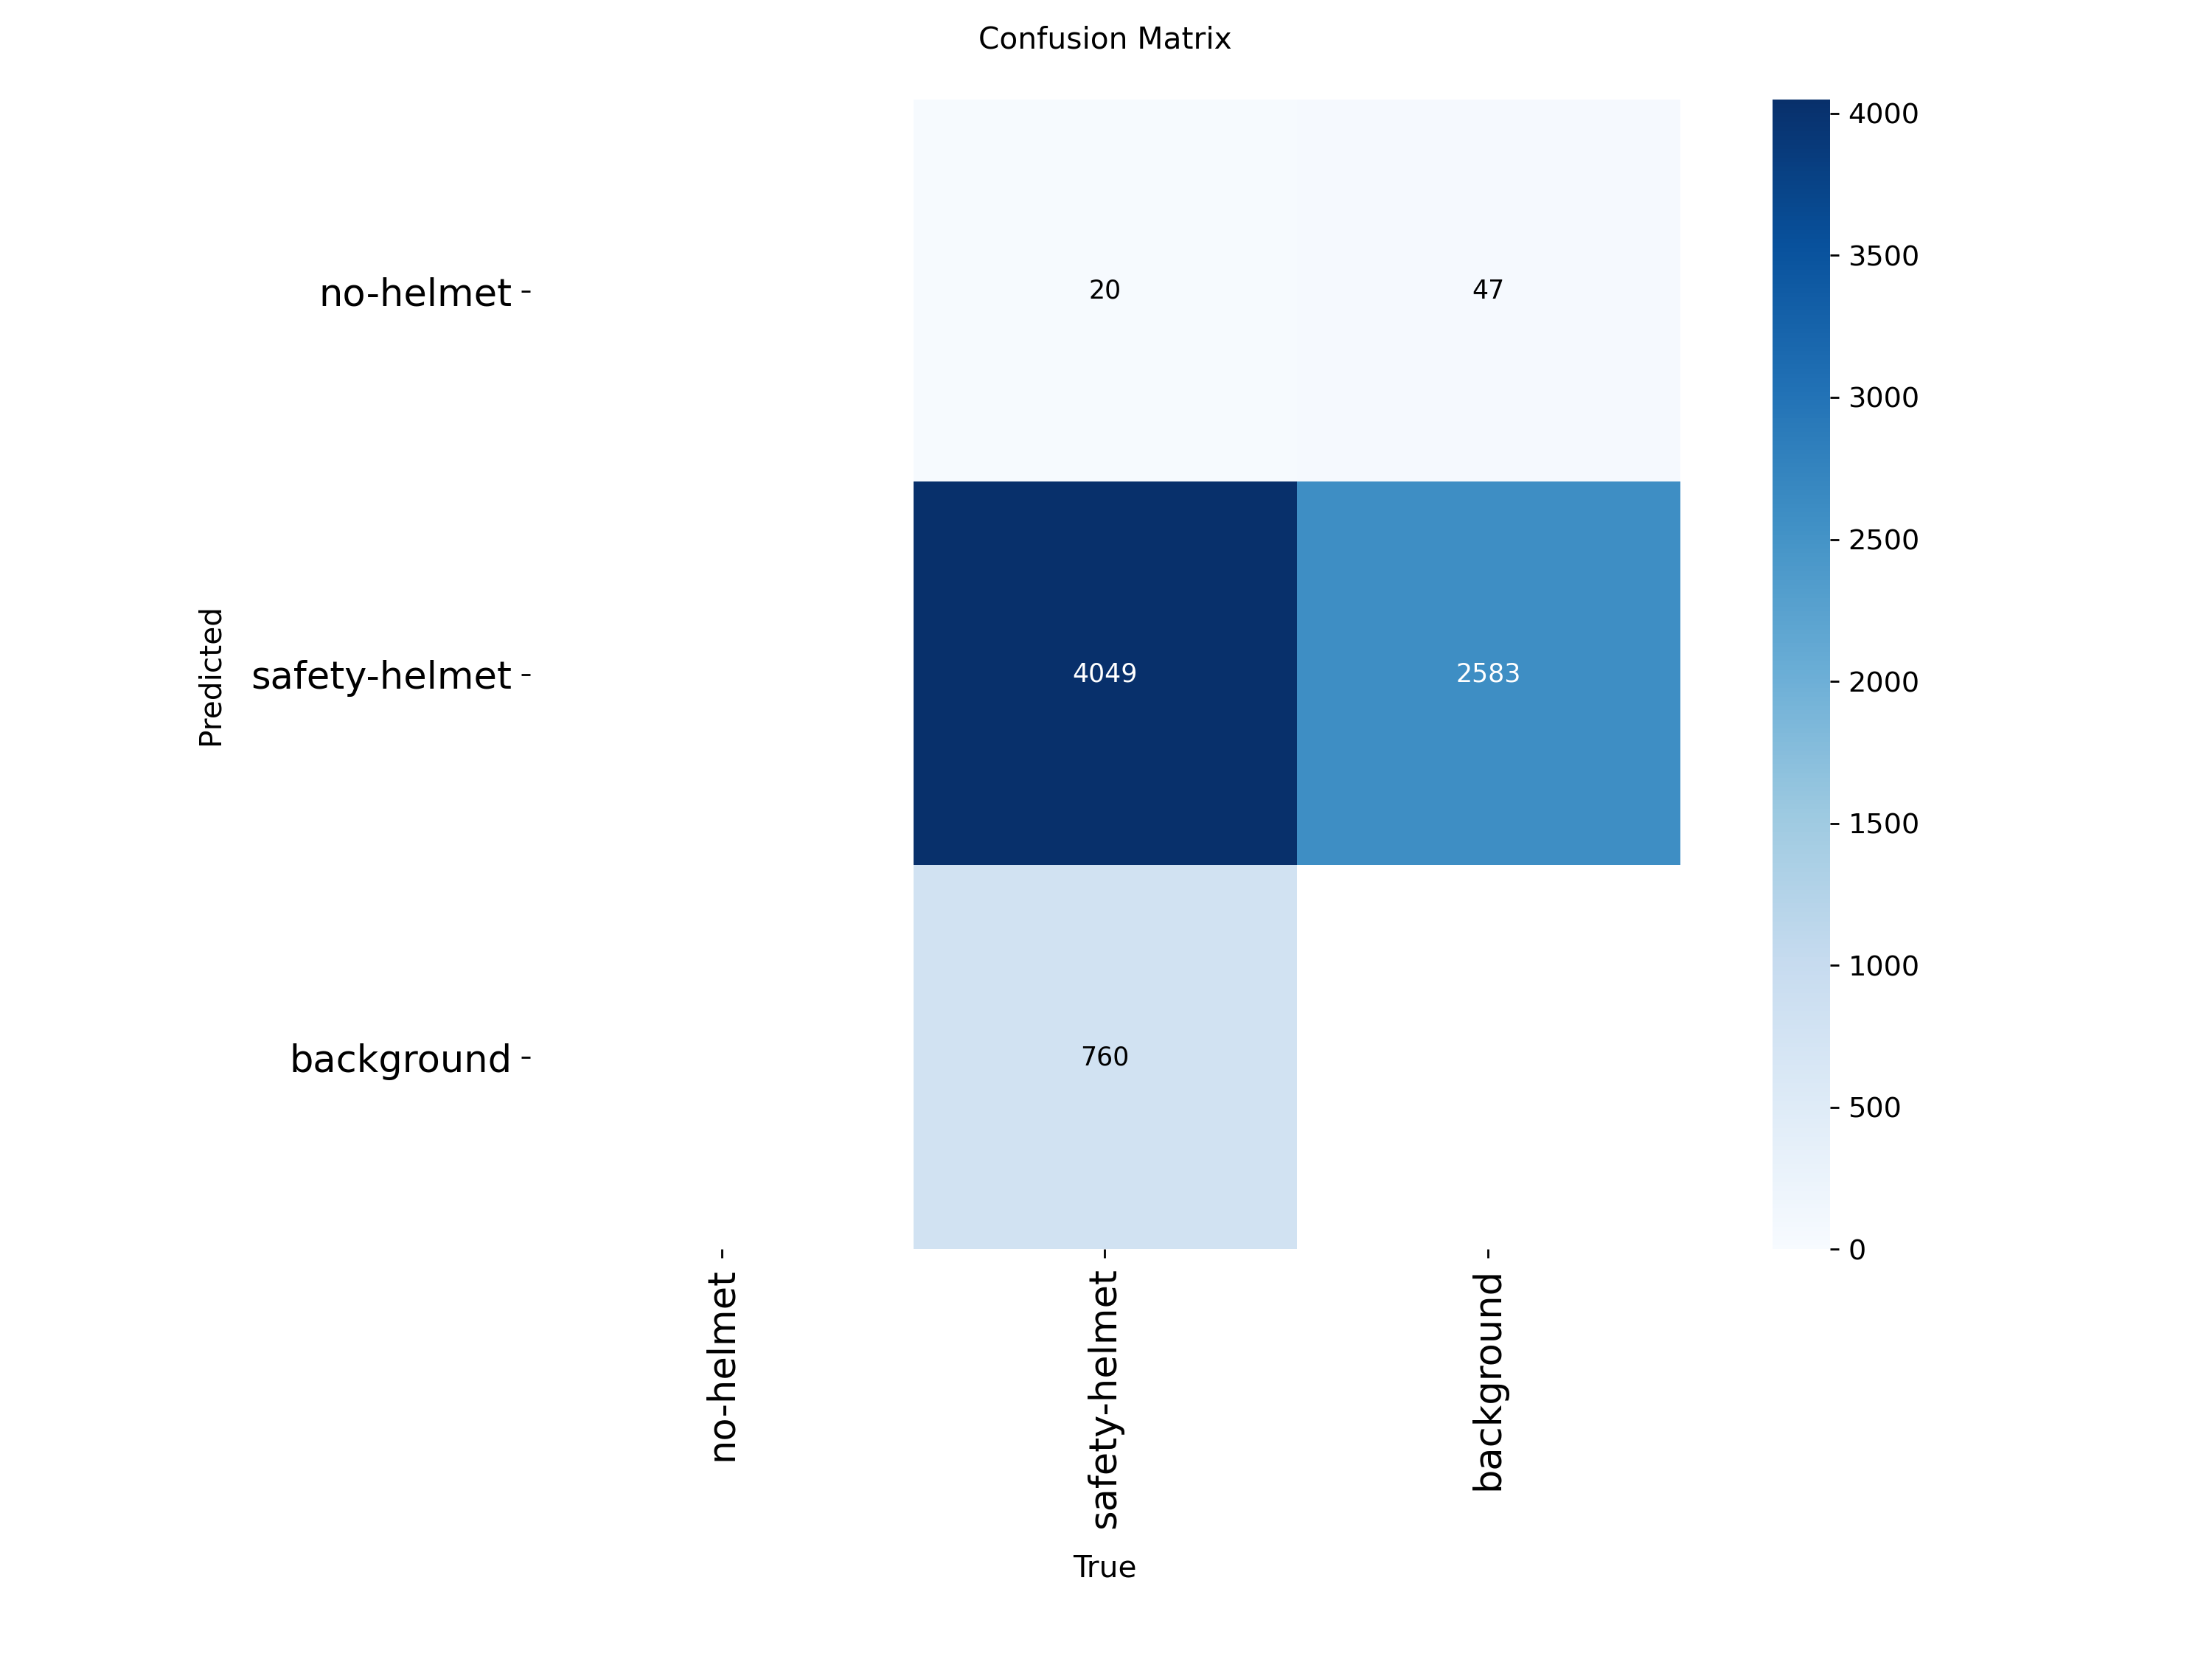

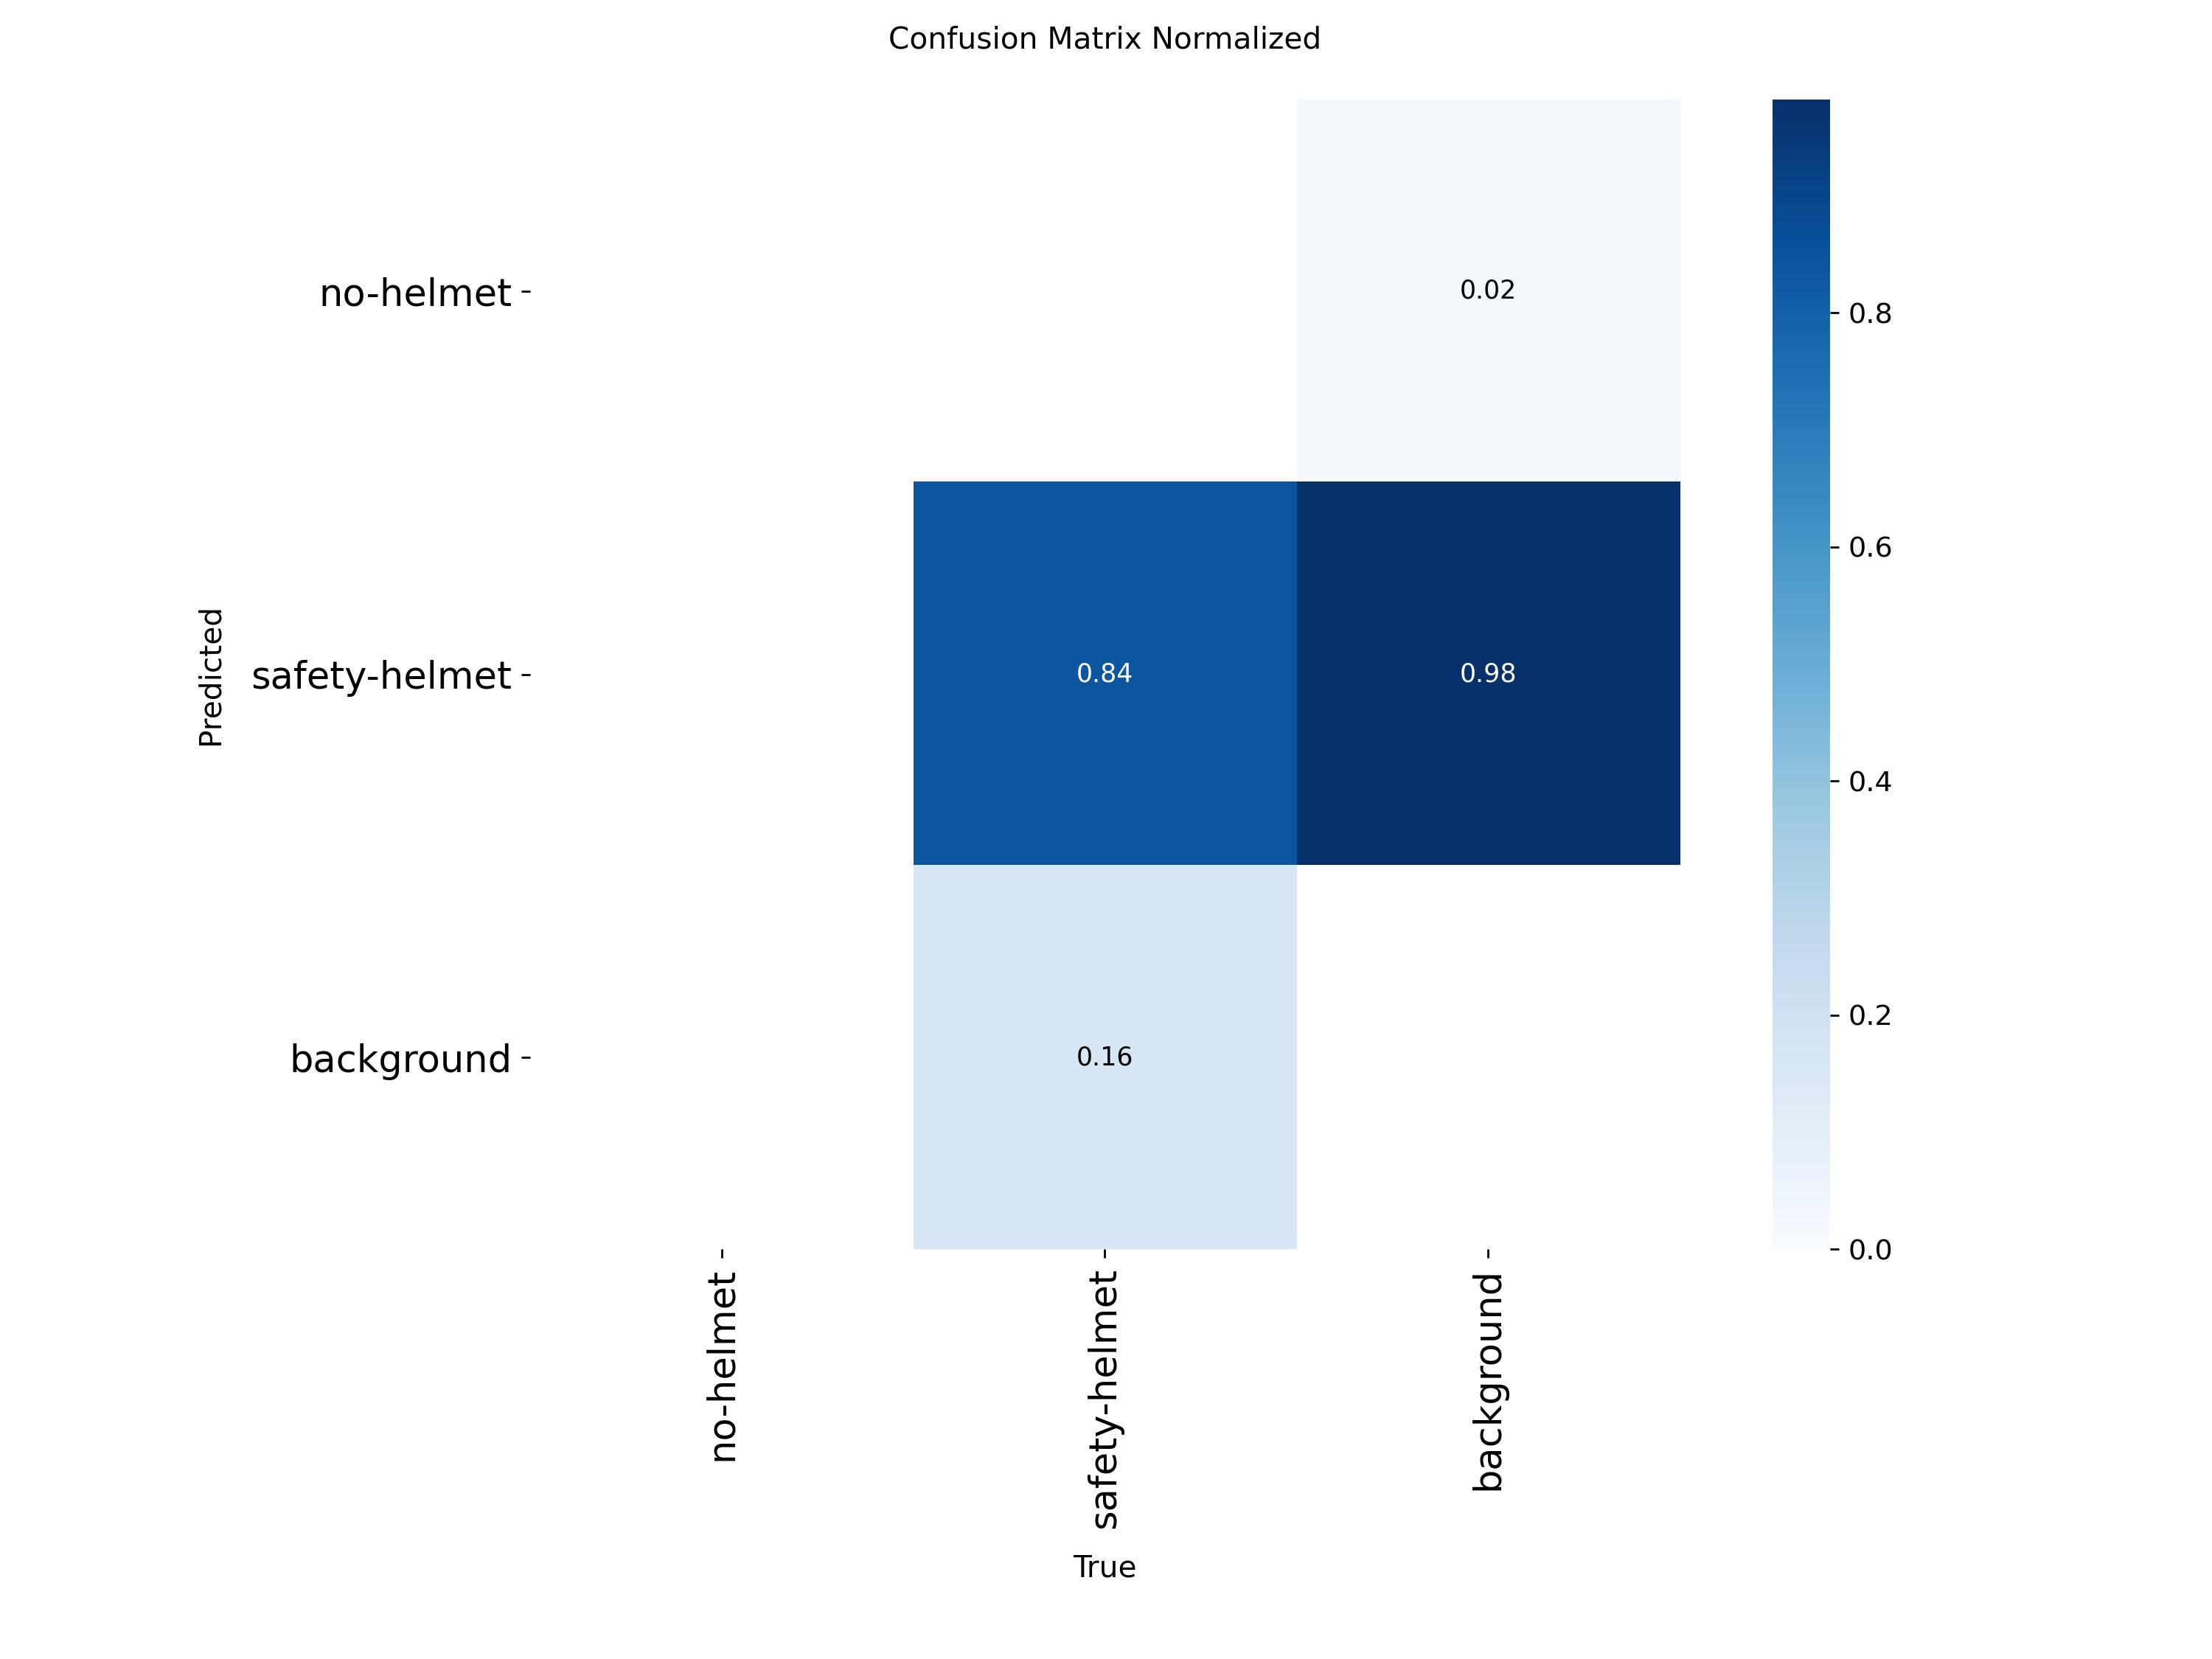

Using results.csv: /content/helmet_yolo_2c/helmet_run/results.csv


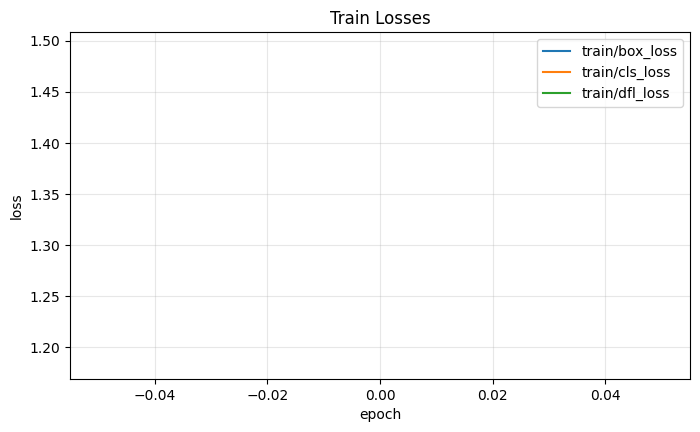

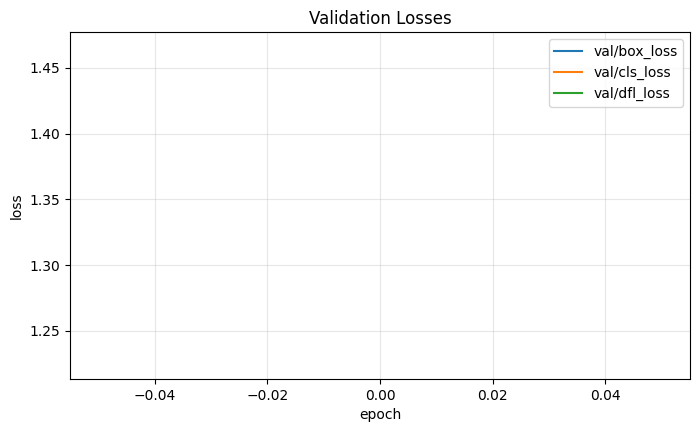

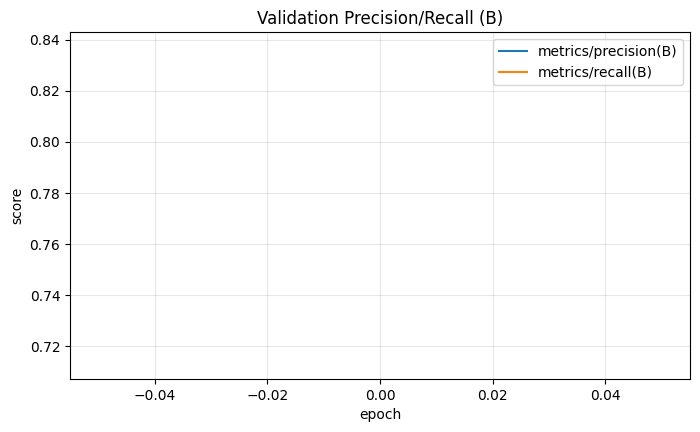

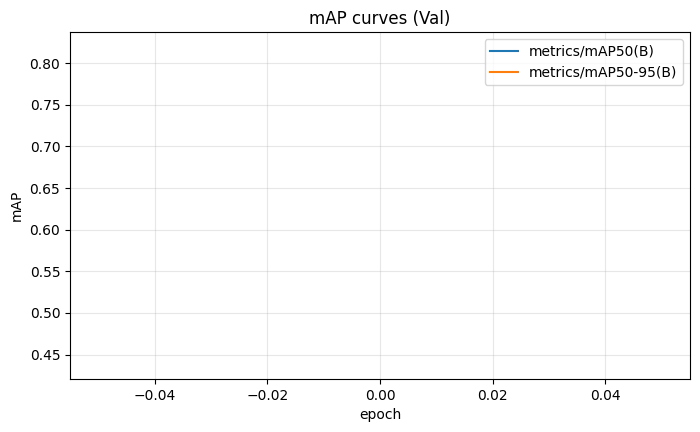

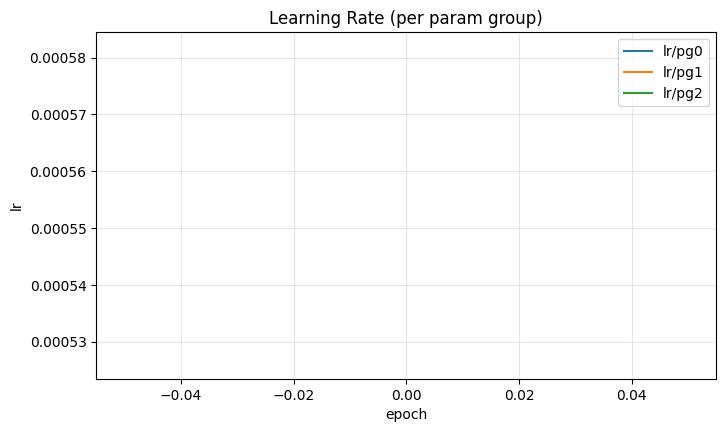

In [ ]:
## Cell 6 — Validate on Test set + ALL dashboards (plots & results.csv)

from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image as ColabImage, display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob, warnings

# -------- 1) Load best.pt ล่าสุด --------
best = None
try:
    best = SAVE_MODEL_PATH
except NameError:
    cands = glob.glob("/content/helmet_yolo_2c/*/weights/best.pt")
    best = Path(sorted(cands, key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]) if cands else None

assert best and Path(best).exists(), "best.pt not found"
model = YOLO(str(best))
print("✅ Loaded model:", best)

# -------- 2) Validate (split=test) และให้ Ultralytics เซฟกราฟมาตรฐาน --------
DATA_YAML = Path('/content/helmet_yolo_2c')/'helmet.yaml'
m = model.val(
    data=str(DATA_YAML),
    split='test',
    imgsz=640,
    project="helmet_yolo_2c",
    name="helmet_test",
    plots=True,       # ให้บันทึกไฟล์กราฟมาตรฐาน
    seed=12345  # กำหนดให้ seed เท่ากันตลอด
)
print("Test metrics:", getattr(m, "results_dict", {}))

# บันทึก path โฟลเดอร์รันนี้ไว้ใช้กับส่วนถัดไป
run_dir = Path(m.save_dir)
print("Run dir:", run_dir)

# -------- 3) แสดงกราฟ/รูปมาตรฐานที่เซฟโดย Ultralytics --------
std_imgs = [
    "results.png","F1_curve.png","PR_curve.png","P_curve.png","R_curve.png",
    "confusion_matrix.png","confusion_matrix_normalized.png",
    "labels.jpg","labels_correlogram.jpg"
]
for name in std_imgs:
    p = run_dir / name
    if p.exists():
        display(ColabImage(filename=str(p)))

# -------- 4) Advanced dashboards จาก results.csv --------
# พยายามหา results.csv ในโฟลเดอร์ run ล่าสุด (บางครั้งผล val จะเขียนลงไดเรกทอรีเดียวกันกับ train)
csv_path = run_dir / "results.csv"
if not csv_path.exists():
    # เผื่อกรณีวิ่งคนละ run; หารันล่าสุดใต้ project
    runs = sorted(glob.glob("/content/helmet_yolo_2c/*/"), key=lambda p: Path(p).stat().st_mtime, reverse=True)
    for r in runs:
        cand = Path(r) / "results.csv"
        if cand.exists():
            csv_path = cand
            break

if csv_path.exists():
    print("Using results.csv:", csv_path)
    df = pd.read_csv(csv_path)

    def plot_series(df, cols, title, ylabel):
        present = [c for c in cols if c in df.columns]
        if not present:
            warnings.warn(f"Skip '{title}' — missing cols: {cols}")
            return
        plt.figure(figsize=(8,4.5))
        for c in present:
            plt.plot(df.index, df[c], label=c)
        plt.title(title)
        plt.xlabel("epoch")
        plt.ylabel(ylabel)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    # 4.1 Train losses
    plot_series(df, ["train/box_loss","train/cls_loss","train/dfl_loss"], "Train Losses", "loss")

    # 4.2 Validation losses
    plot_series(df, ["val/box_loss","val/cls_loss","val/dfl_loss"], "Validation Losses", "loss")

    # 4.3 Precision / Recall (val)
    plot_series(df, ["metrics/precision(B)","metrics/recall(B)"], "Validation Precision/Recall (B)", "score")

    # 4.4 mAP@.5 และ mAP@.5:.95
    plot_series(df, ["metrics/mAP50(B)","metrics/mAP50-95(B)"], "mAP curves (Val)", "mAP")

    # 4.5 Learning rate (ถ้ามีใน CSV)
    plot_series(df, ["lr/pg0","lr/pg1","lr/pg2"], "Learning Rate (per param group)", "lr")

else:
    print("⚠️ results.csv not found — graphs from CSV are skipped.")


## Cell 7 — Helper: load latest model + rule-based filter

In [10]:
from pathlib import Path
import cv2
from typing import Optional, Tuple

from ultralytics import YOLO

PROJECT_NAME = "helmet_yolo_2c"

def find_latest_best(project: str) -> Optional[Path]:
    p = Path(project)
    if not p.exists(): return None
    runs = sorted(p.glob("*/weights/best.pt"), key=lambda x: x.stat().st_mtime, reverse=True)
    return runs[0] if runs else None

# A simple rule to filter out many caps: too small, too tall, too narrow, or too close to top border
def plausible_helmet_box(x1, y1, x2, y2, img_w, img_h):
    w = max(1, x2 - x1)
    h = max(1, y2 - y1)
    area = w * h
    img_area = img_w * img_h

    x, y = x1, y1
    # Basic constraints
    if area < 0.005 * img_area:    # too small
        return False
    if h / float(w) > 1.6:         # overly tall
        return False
    if w / float(h) < 0.5:         # overly narrow
        return False
    if y < 0.02 * img_h:           # touching the very top
        return False
    return True

def load_latest_model():
    best = find_latest_best(PROJECT_NAME)
    assert best and best.exists(), "best.pt not found — run training first"
    model = YOLO(str(best))
    return model

def draw_with_rule(img, res, conf_thr=0.35, safety_thr=0.80):
    h, w = img.shape[:2]
    announced = False
    for b in res.boxes:
        cls = int(b.cls[0])
        conf = float(b.conf[0])
        x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
        name = res.names[cls]

        # default color red (assume no-helmet) / green for safety-helmet
        color = (0,255,0) if name == "safety-helmet" else (0,0,255)
        show_label = True

        if name == "safety-helmet":
            if conf < safety_thr:
                # below 0.80 → treat as no-helmet
                name = "no-helmet"
                color = (0,0,255)
            else:
                # apply shape/position heuristics to reduce cap false positives
                if not plausible_helmet_box(x1,y1,x2,y2,w,h):
                    name = "no-helmet"
                    color = (0,0,255)

        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        cv2.putText(img, f"{name} {conf:.2f}", (x1, max(20, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # banner message (once per frame)
        if not announced:
            if name == "safety-helmet":
                msg = "Thank you for wearing a safety helmet"
                banner = (0,128,0)
            else:
                msg = "Please wear a safety helmet"
                banner = (0,0,255)
            cv2.rectangle(img, (0,0), (w, 44), banner, -1)
            cv2.putText(img, msg, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
            announced = True
    return img

In [ ]:
## Cell 8 — Download Model

In [12]:
from google.colab import files
from pathlib import Path

# Path ไปยัง best.pt หลังเทรนเสร็จ
SAVE_MODEL_PATH = Path("/content/helmet_yolo_2c/helmet_run/weights/best.pt")

if SAVE_MODEL_PATH.exists():
    print("✅ Found best.pt:", SAVE_MODEL_PATH)
    files.download(str(SAVE_MODEL_PATH))
else:
    print("❌ best.pt not found — check training output")


✅ Found best.pt: /content/helmet_yolo_2c/helmet_run/weights/best.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>